# Offset Parabolas Caused by Distributional Mismatch

In [3]:
%run imports.py

seed = 4
np.random.seed(seed)
tf.random.set_seed(seed)

All packages loaded successfully.


In [4]:
# --- Generate synthetic 2D data ---
def true_function(X):
    return 0.1*X**2


n = 1000
noise = 0.01
X = np.random.normal(3, 1, size=n)
y = true_function(X) + np.random.normal(0, noise, size=n)

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

kf = KFold(n_splits=10, shuffle=True, random_state=0)
X_train, X_test, y_train, y_test = None, None, None, None
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break


y_mean, y_std = np.mean(y_train), np.std(y_train)
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

In [5]:
print("OAK with a Gaussian Measure N(0,1) ...")
# --- Create AGP model ---
data = (X_train, y_train)
model = create_model_oak(
        data=data,
        max_interaction_depth=1,
        constrain_orthogonal=True,
        share_var_across_orders=True,
        use_sparsity_prior=False,
)


# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))


# --- Print model summary ---
gpflow.utilities.print_summary(model)
print(model.training_loss().numpy())




print("OAK with a Gaussian Measure N(3,1) ...")
custom_measure = MOGMeasure(means=np.array([3.0]), variances=np.array([1.0]), weights=np.array([1.0]))
gmm_measures_list = [custom_measure, custom_measure]


# --- Create AGP model ---
model1 = create_model_oak(
         data=data,
         max_interaction_depth=1,
         constrain_orthogonal=True,
         share_var_across_orders=True,
         use_sparsity_prior=False,
         gmm_measures=gmm_measures_list,
)
model1.kernel.kernels[0].base_kernel.variance.assign(1.0)
gpflow.set_trainable(model1.kernel.kernels[0].base_kernel.variance, False)


# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model1.training_loss, model1.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))


# --- Print model summary ---
gpflow.utilities.print_summary(model1)
print(model1.training_loss().numpy())

OAK with a Gaussian Measure N(0,1) ...
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │          value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════╡
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   11.9223      │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.variances[0]                        │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    2.23653     │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼────────────

In [6]:
def plot_components(model):

    alpha = get_model_sufficient_statistics(model, get_L=False)
    selected_dims, kernel_list = get_list_representation(model.kernel, num_dims=1)
    K = model.kernel.K(X_train, X_train) + tf.eye(X_train.shape[0], dtype=tf.float64) * model.likelihood.variance.numpy()

    mu0 = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))
    mu1 = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))
    mu = eval_component(model.kernel, alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))

    f0 = mu0*y_std + y_mean
    f1 = mu1*y_std
    f = mu*y_std + y_mean

    var_f1_tensor = get_component_variance(kernel_list[1], K, X_test_tf, X_train)
    var_f1 = var_f1_tensor.numpy()
    std_f1_oak = np.sqrt(var_f1).reshape(-1,1) * y_std

    var_f0_tensor = get_component_variance(kernel_list[0], K, X_test_tf, X_train)
    var_f0 = var_f0_tensor.numpy()
    std_f0_oak = np.sqrt(var_f0).reshape(-1,1) * y_std

    var_f_tensor = get_component_variance(model.kernel, K, X_test_tf, X_train)
    var_f = var_f_tensor.numpy()
    std_f_oak = np.sqrt(var_f).reshape(-1,1) * y_std

    return f0, f1, f, std_f0_oak, std_f1_oak, std_f_oak
    

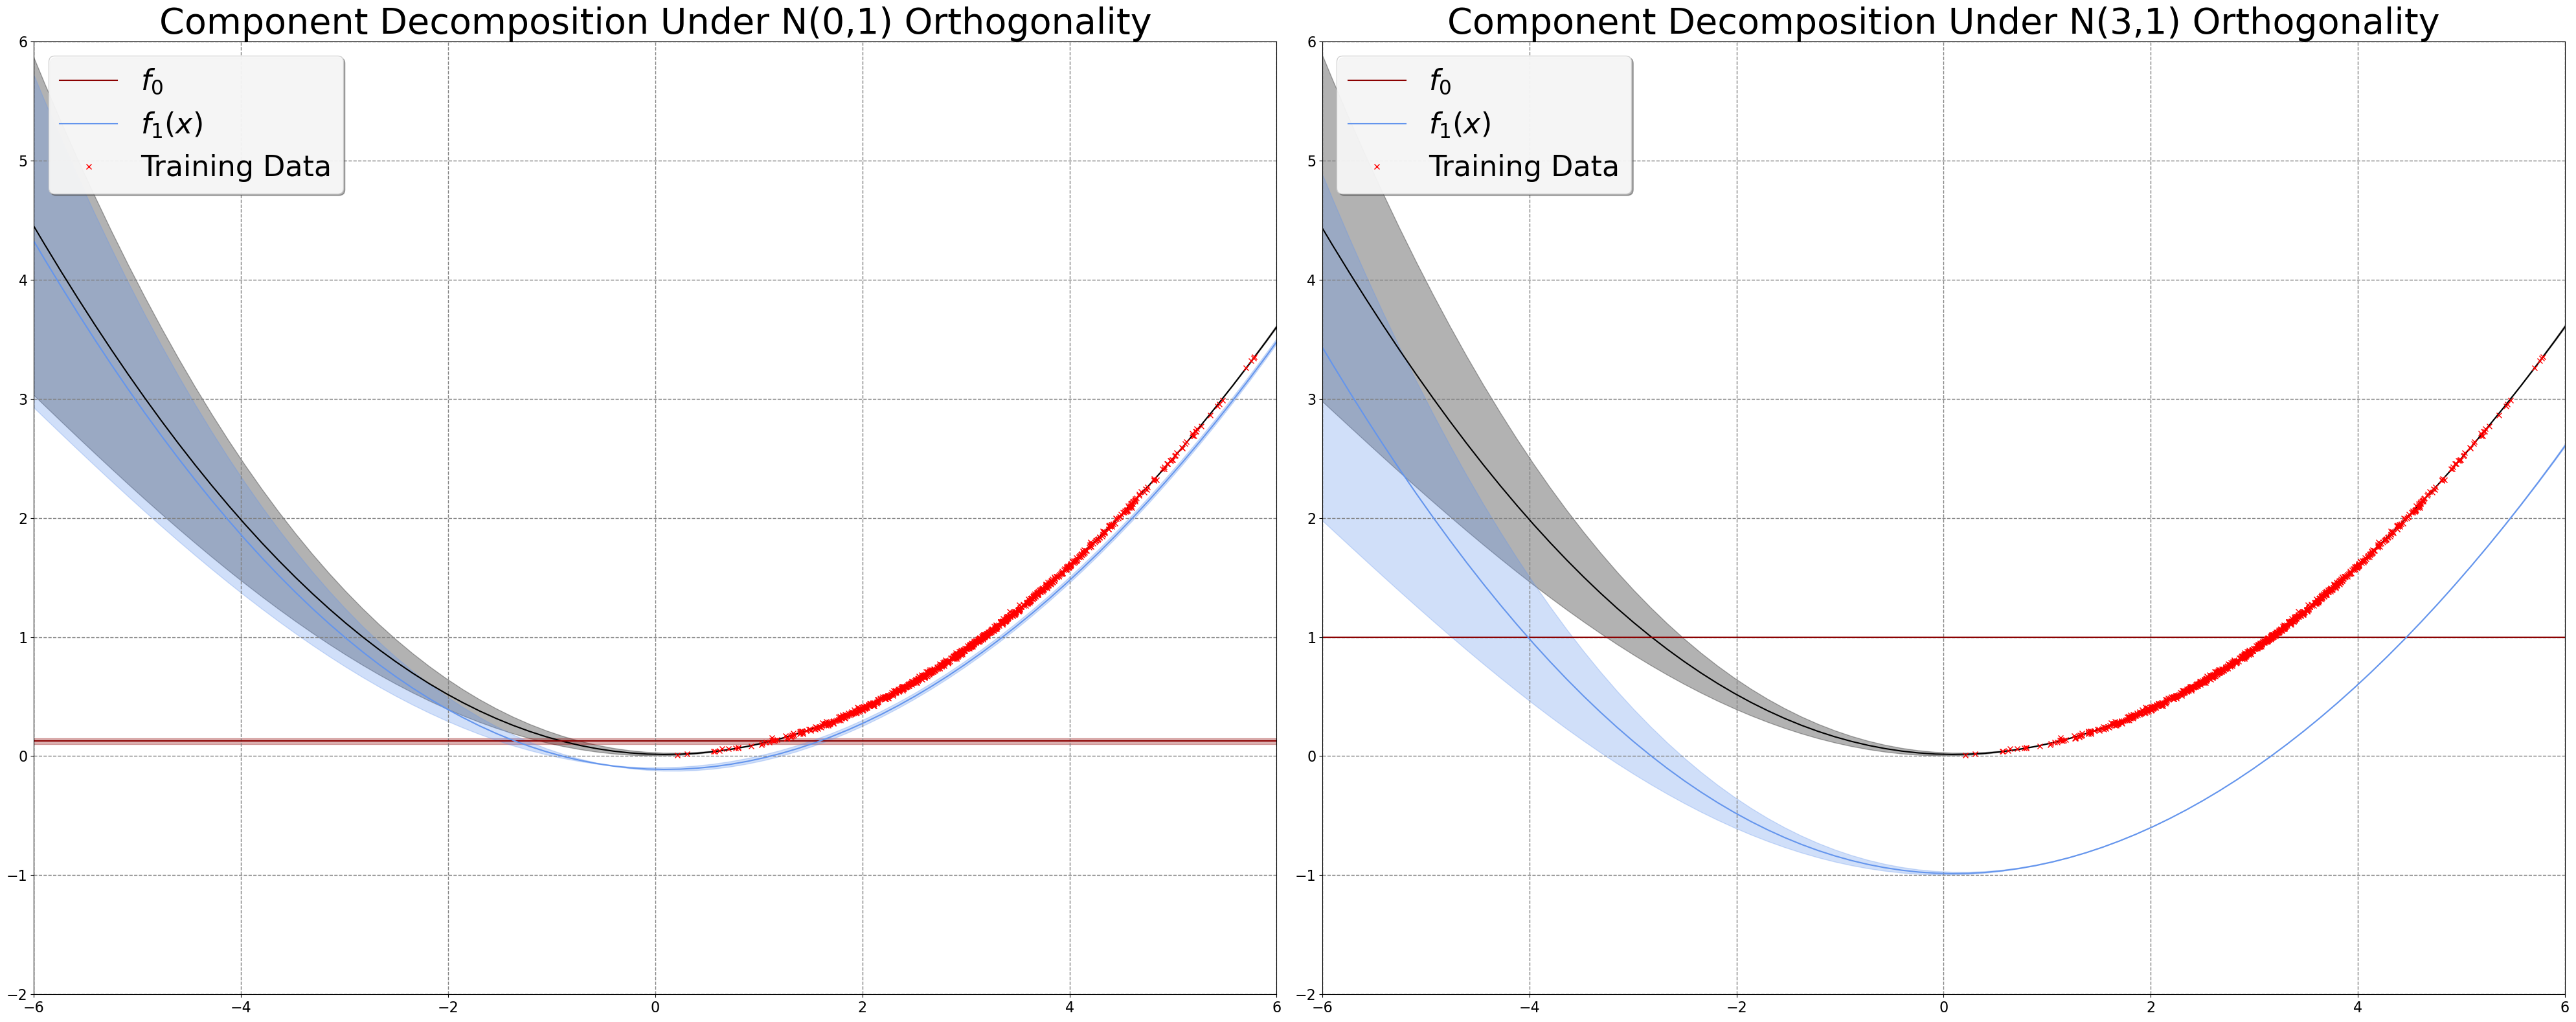

In [7]:
b = 8
x1_plot = np.linspace(-b, b, 100).reshape(-1,1)
X_test_tf = tf.convert_to_tensor(x1_plot, dtype=tf.float64)
X_test_tf = tf.reshape(X_test_tf, [-1, 1])


mu0, mu1, mu, std_f0_oak, std_f1_oak, std_f_oak = plot_components(model)
mu0_1, mu1_1, mu_1, std_f0_oak_1, std_f1_oak_1, std_f_oak_1 = plot_components(model1)



low1 = (mu1 - 2*std_f1_oak).reshape(100)
high1 = (mu1 + 2*std_f1_oak).reshape(100)
low0 = (mu0 - 2*std_f0_oak).reshape(100)
high0 = (mu0 + 2*std_f0_oak).reshape(100)
low = (mu - 2*std_f_oak).reshape(100)
high = (mu + 2*std_f_oak).reshape(100)

low1_1 = (mu1_1 - 2*std_f1_oak_1).reshape(100)
high1_1 = (mu1_1 + 2*std_f1_oak_1).reshape(100)
low0_1 = (mu0_1 - 2*std_f0_oak_1).reshape(100)
high0_1 = (mu0_1 + 2*std_f0_oak_1).reshape(100)
low_1 = (mu_1 - 2*std_f_oak_1).reshape(100)
high_1 = (mu_1 + 2*std_f_oak_1).reshape(100)



# --- Plot the component decomposition ---
fig, axes = plt.subplots(1, 2, figsize=(40, 16))
y_orig = y_train * y_std + y_mean

axes[0].plot(x1_plot, mu, color='black')
axes[0].fill_between(x1_plot.reshape(100), low, high, color='black', alpha=0.3)
axes[0].plot(x1_plot.reshape(100), mu0, label='$f_0$', color='darkred')
axes[0].fill_between(x1_plot.reshape(100), low0, high0, color='darkred', alpha=0.3)
axes[0].plot(x1_plot.reshape(100), mu1, label='$f_1(x)$', color='cornflowerblue')
axes[0].fill_between(x1_plot.reshape(100), low1, high1, color='cornflowerblue', alpha=0.3)
axes[0].plot(X_train, y_orig, 'x', color='red', label='Training Data')
axes[0].set_title("Component Decomposition Under N(0,1) Orthogonality", fontsize=40)
axes[0].grid(True)
axes[0].set_xlim([-6,6])
axes[0].set_ylim([-2,6])
axes[0].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9, fontsize=32)

axes[1].plot(x1_plot, mu_1, color='black')
axes[1].fill_between(x1_plot.reshape(100), low_1, high_1, color='black', alpha=0.3)
axes[1].plot(x1_plot.reshape(100), mu0_1, label='$f_0$', color='darkred')
axes[1].fill_between(x1_plot.reshape(100), low0_1, high0_1, color='darkred', alpha=0.3)
axes[1].plot(x1_plot.reshape(100), mu1_1, label='$f_1(x)$', color='cornflowerblue')
axes[1].fill_between(x1_plot.reshape(100), low1_1, high1_1, color='cornflowerblue', alpha=0.3)
axes[1].plot(X_train, y_orig, 'x', color='red', label='Training Data')
axes[1].set_title("Component Decomposition Under N(3,1) Orthogonality", fontsize=40)
axes[1].grid(True)
axes[1].set_xlim([-6,6])
axes[1].set_ylim([-2,6])
axes[1].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9, fontsize=32)

plt.tight_layout()
plt.show()